In [199]:
import numpy as np
from nim_env import NimEnv, OptimalPlayer
import random
import matplotlib.pyplot as plt
from IPython import display

env = NimEnv(seed = 3)


In [345]:
class plotAvg:
    def __init__(self):
        self.count = 0
        self.R = []
        self.reward_sum = 0
     
    def plot(self):
        self.count += 1
        self.reward_sum /= 249.
        append = [250*self.count, self.reward_sum]
        self.R.append(append)
        Rplot = np.array(self.R)
        display.clear_output(wait = True)
        plt.plot(Rplot[:,0], Rplot[:,1])
        plt.xlabel('Games played')
        plt.ylabel('average reward')
        plt.show() 
        self.reward_sum = 0.0
        
class plotM:
    def __init__(self):
        self.Mopt = []
        self.Mrand = []
        self.Mlist = []
        self.count = 0
        
    def plot(self):
        self.count += 1
        append = [250*self.count, self.Mopt, self.Mrand]
        self.Mlist.append(append)
        Mplot = np.array(self.Mlist)
        display.clear_output(wait = True)
        plt.plot(Mplot[:,0], Mplot[:,1], color='g', label='Mopt')
        plt.plot(Mplot[:,0], Mplot[:,2], color='r', label='Mrand')
        plt.xlabel('Games played')
        plt.ylabel('performance M')
        plt.legend()
        plt.show()
        

In [339]:
def check_valid(state, action):
    heap, n_sticks = map(int, action)
    if (state[heap - 1] == 0):
        return False
    if n_sticks < 1:
        return False
    if n_sticks > state[heap - 1]:
        return False
    return True

In [340]:
def epsilonPolicy(Q, state, epsilon):
    
    possible_action = []
    
    for action1 in range(3):
        for action2 in range(7):
            check_action = np.array([action1+1, action2+1])
            if (check_valid(state, check_action) == True):
                check_action -= 1
                possible_action.append(check_action)
    
    size_possible_action = len(possible_action)
    possible_action = possible_action*np.ones((size_possible_action,1))

    Q_possible_action = Q[  state[0]*np.ones(size_possible_action).astype(int),
                            state[1]*np.ones(size_possible_action).astype(int),
                            state[2]*np.ones(size_possible_action).astype(int),
                            possible_action[:,0].astype(int),
                            possible_action[:,1].astype(int)]
    
    rd = np.random.uniform(0, 1)
    if ( rd <= epsilon):
        idx = np.random.choice(size_possible_action)
        action = possible_action[idx,:]
        action += 1
    else:
        idx_max = np.argmax(Q_possible_action)
        action = possible_action[idx_max,:]
        action += 1

    action =  action.astype(int)
    
    return action

In [341]:
def qUpdate(Q, old_state, state, action, player_ai, discount_factor, alpha):
    
    Qold = Q[old_state[0], old_state[1], old_state[2], action[0]-1, action[1]-1]
    
    if (np.count_nonzero(state) > 0):
        greedy_next_action = epsilonPolicy(Q, state, 0.0)
        Qnext = Q[state[0],state[1], state[2], greedy_next_action[0]-1, greedy_next_action[1]-1]
    else:
        Qnext = 0.0
        
    Qold +=  alpha*(env.reward(player = player_ai) + discount_factor*Qnext - Qold)
    Q[old_state[0], old_state[1], old_state[2], action[0]-1, action[1]-1] = Qold
    
    return Q

In [363]:
def qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.1):
    
    Q = np.zeros((8,8,8,3,8))
    plot = plotAvg()
    mplot = plotM()

    Turns = np.array([0,1])
    epsilon_min = 0.0
    epsilon_max = 0.8
    
    for ith_episode in range(num_episodes):
        Turns = Turns[np.random.permutation(2)]
        epsilon = max(epsilon_min, epsilon_max*(1-2*ith_episode/num_episodes))
        
        player_opt = OptimalPlayer(epsilon=0.1, player = Turns[0])
        player_ai = Turns[1]
        state = env.reset()
        next_state = np.copy(state)
        end = False
        
        if (env.current_player == Turns[0]): # if the first turn is for the opt(0.5)
            action = player_opt.act(state)
            state,end,winner = env.step(action)
        
        while (end == False):
            
            action = epsilonPolicy(Q, state, epsilon)   #agent plays
            old_state = np.copy(state)
            state, end,winner = env.step(action) # state which the agent gives to opt(0.5)
            if (end == True): break
            
            actionOpt = player_opt.act(state) #opt(0.5) plays
            state,end,winner = env.step(actionOpt) #state which opt(0.5) gives back
            if (end == True): break
            Q = qUpdate(Q, old_state, state, action, player_ai, discount_factor, alpha)
            
        Q = qUpdate(Q, old_state, state, action, player_ai, discount_factor, alpha) # update with the terminal state
        
        plot.reward_sum += env.reward(player=player_ai) 
        
        if (ith_episode%250 == 249):
            #plot.plot()
            mplot.Mopt = performance(Q, num_games = 500, epsilonOpt = 0.0)
            mplot.Mrand = performance(Q, num_games = 500, epsilonOpt = 1.0)
            mplot.plot()
            
            

    return Q

In [364]:
def performance(Q, num_games = 500, epsilonOpt = 0.0):
    
    Turns = np.array([0,1])
    N_lost = 0
    N_win = 0
    
    for ith_episode in range(num_games):
        Turns = Turns[np.random.permutation(2)]
        
        player_opt = OptimalPlayer(epsilon = epsilonOpt, player = Turns[0])
        player_ai = Turns[1]
        state = env.reset()
        end = False
        
        while (end == False):
            if (env.current_player == Turns[0]):
                action = player_opt.act(state) 
                state,end,winner = env.step(action)
            else: 
                action = epsilonPolicy(Q, state, epsilon = 0.0)
                state,end,winner = env.step(action)
        if (winner == player_ai): N_win += 1
        else: N_lost += 1
    
    M = (N_win - N_lost)/num_games
        
    return M
            
            

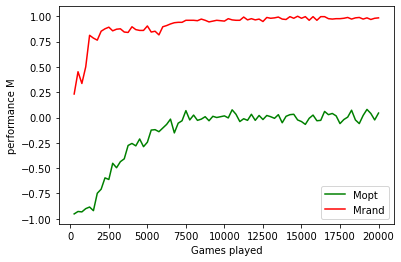

In [365]:
Q = qLearning_against_Opt(env, num_episodes = 20000, epsilon = 0.1)